# Causal Inference and Discovery in Python

## Chapter 06 - Nodes, Edges, and Statistical (In)dependence

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import graphviz
from scipy import stats
import statsmodels.api as sm
from itertools import combinations

plt.style.use('fivethirtyeight')
COLORS = ['#00B0F0','#FF0000']

## Visualizations

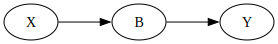

In [3]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'B', 'Y']
positions = ['1,0!', '2.5,0!', '4,0!']

edges = ['XB', 'BY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_00')

graph

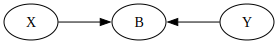

In [4]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'B', 'Y']
positions = ['1,0!', '2.5,0!', '4,0!']

edges = ['XB', 'YB']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_01')

graph

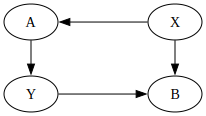

In [5]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y']
positions = ['1,1!', '3,1!', '3,0!', '1, 0!']

edges = ['XB', 'YB', 'XA', 'AY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_02')

graph

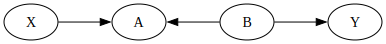

In [6]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y']
positions = ['1.5,0!', '0,0!', '3,0!', '4.5,0!']

edges = ['XA', 'BA', 'BY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_03')

graph

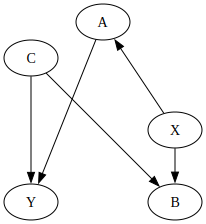

In [7]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y', 'C']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!']

edges = ['XA', 'XB', 'CB', 'CY', 'AY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_06_d_sep_04')

graph

## Estimand first!

In [8]:
# Commute example
t = [22.1, 23.7, 25.2, 20.0, 21.8]

np.mean(t)

22.56

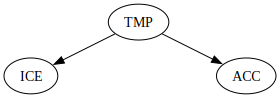

In [9]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['ICE', 'TMP', 'ACC']
positions = ['0,0!', '1.5,.75!', '3,0!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edge('TMP', 'ICE')
graph.edge('TMP', 'ACC')

#graph.render(f'images/ch_06_icecream')

graph

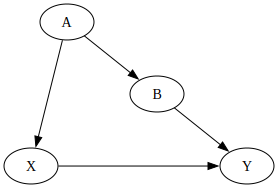

In [10]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'A', 'B']
positions = ['0,0!', '3,0!', '.5,2!', '1.75,1!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(['XY', 'AX', 'AB', 'BY'])

#graph.render(f'images/ch_06_equivalent_estimands_00')

graph

In [11]:
#?graph.edge

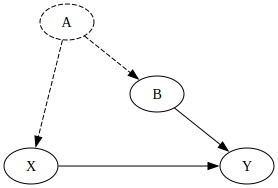

In [12]:
graph = graphviz.Digraph(format='png', engine='neato')


nodes = ['X', 'Y', 'A', 'B']
positions = ['0,0!', '3,0!', '.5,2!', '1.75,1!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('A', style='dashed')

graph.edges(['XY', 'BY'])
graph.edge('A', 'X', style='dashed')
graph.edge('A', 'B', style='dashed')

#graph.render(f'images/ch_06_equivalent_estimands_01')

graph

## Front-door criterion

In [13]:
from dowhy.causal_model import CausalModel

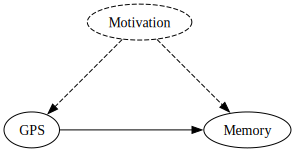

In [14]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['GPS', 'Memory', 'Motivation']
positions = ['0,0!', '3,0!', '1.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Memory')

#graph.render(f'images/ch_06_gps_01')

graph

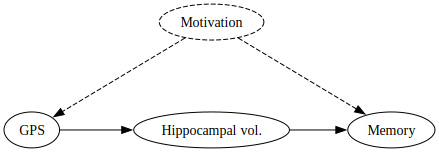

In [15]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['GPS', 'Hippocampal vol.', 'Memory', 'Motivation']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Hippocampal vol.')
graph.edge('Hippocampal vol.', 'Memory')

#graph.render(f'images/ch_06_gps_02')

graph

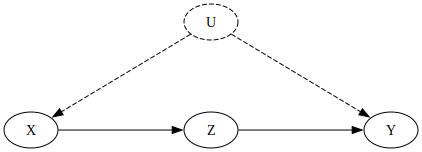

In [16]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Z', 'Y', 'U']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('X', 'Z')
graph.edge('Z', 'Y')

#graph.render(f'images/ch_06_gps_03')

graph

### Front-door in practice

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [19]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(600)

# Run an experiment
treatments = []
experiment_results = []

# Sample over various treatments
for treatment in np.arange(1, 21):
    gps_hours, hippocampus, memory = scm.intervene(treatment_value=treatment, sample_size=30)
    experiment_results.append(memory)
    treatments.append(gps_hours)

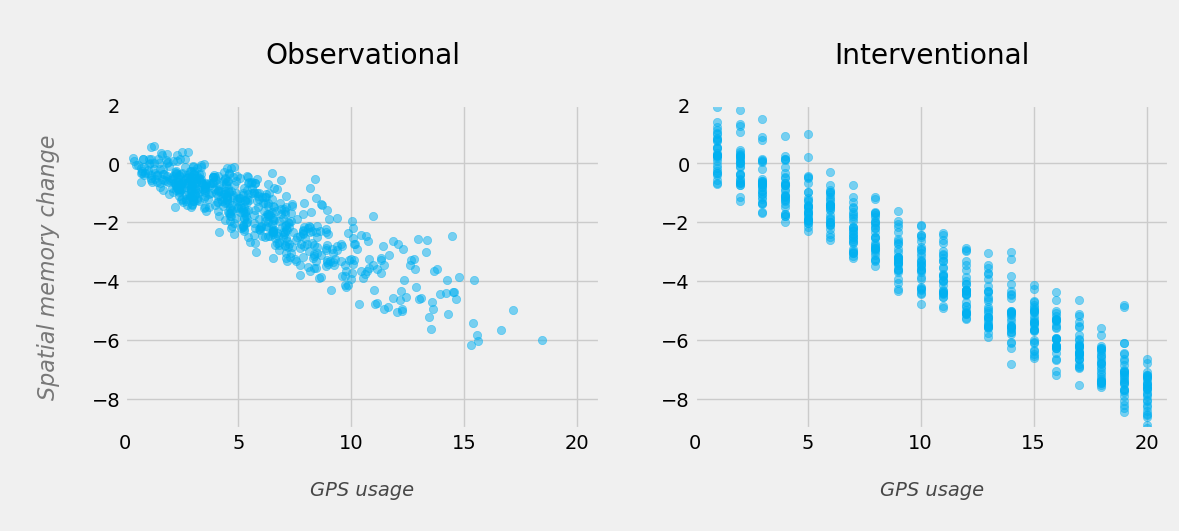

In [20]:
# Plot observational data
plt.figure(figsize=(12, 4))

# Observational
plt.subplot(121)
plt.scatter(gps_obs, memory_obs, alpha=.5, color=COLORS[0])
plt.xlim(0, 21)
plt.ylim(-9, 2)

plt.title('\nObservational\n')
plt.xlabel('\nGPS usage', alpha=.7, fontsize=14, style='italic')
plt.ylabel('\nSpatial memory change\n', alpha=.5, fontsize=16, style='italic')


# Interventional
plt.subplot(122)

plt.scatter(treatments, experiment_results, alpha=.5, color=COLORS[0])
plt.xlim(0, 21)
plt.ylim(-9, 2)

plt.title('\nInterventional\n')
plt.xlabel('\nGPS usage\n', alpha=.7, fontsize=14, style='italic')

plt.show()

### Naive model 1

In [21]:
lr_naive = LinearRegression()
lr_naive.fit(
    X=gps_obs.reshape(-1, 1), 
    y=memory_obs
)

LinearRegression()

### Experimental model

In [22]:
treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()

lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1), 
    y=results_unpack
)

LinearRegression()

In [23]:
X_test = np.arange(1, 21).reshape(-1, 1)

preds_naive = lr_naive.predict(X_test) 
preds_experiment = lr_experiment.predict(X_test)

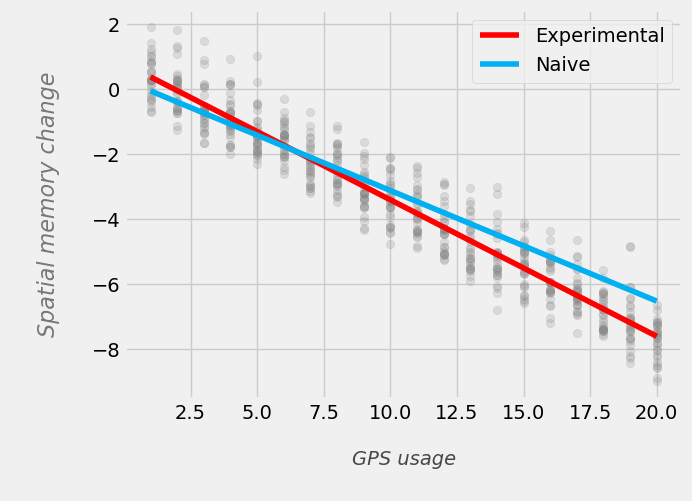

In [24]:
plt.scatter(treatments, experiment_results, alpha=.2, color='gray')
plt.plot(X_test, preds_experiment, label='Experimental', color=COLORS[1])
plt.plot(X_test, preds_naive, label='Naive', color=COLORS[0])

plt.xlabel('\nGPS usage\n', alpha=.7, fontsize=14, style='italic')
plt.ylabel('\nSpatial memory change\n', alpha=.5, fontsize=16, style='italic')

plt.legend()
plt.show()

In [25]:
# Get coefficients
print(f'Naive model:\n{lr_naive.coef_[0]}\n')
print(f'Experiemntal model:\n{lr_experiment.coef_[0]}')

Naive model:
-0.34066726571858924

Experiemntal model:
-0.4203507851071551


## The Linear Bridge to The Causal Promised Land

In [26]:
from dowhy.causal_model import CausalModel
from sklearn.linear_model import LinearRegression

In [27]:
# Model E(Z|X)
lr_zx = LinearRegression()
lr_zx.fit(
    X=gps_obs.reshape(-1, 1),
    y=hippocampus_obs
)

# Model E(Y|X, Z)E(X)
lr_yxz = LinearRegression()
lr_yxz.fit(
    X=np.array([gps_obs,hippocampus_obs]).T,
    y=memory_obs
)

# Compute the expected causal effect
lr_zx.coef_[0] * lr_yxz.coef_[1]

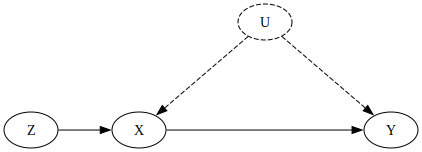

In [28]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['Z', 'X', 'Y', 'U']
positions = ['0,0!', '1.5,0!', '5,0!', '3.25,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('Z', 'X')
graph.edge('X', 'Y')

#graph.render(f'images/ch_06_instrumental_00')

graph

In [29]:
# First, we'll build a structural causal model (SCM)
class InsrumentalSCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_xy = stats.norm()
        self.u_z = stats.norm()
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_xy = self.u_xy.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        
        z = u_z
        x = 0.7*z + 0.2*u_xy
        y = 0.8*x + 0.1*u_xy
        
        return z, x, y

In [30]:
# Instantiate the SCM and sample
instr_scm = InsrumentalSCM()
z, x, y = instr_scm.sample(1000)

In [31]:
# Fit regression 1
lr_yz = LinearRegression()
lr_yz.fit(X=z.reshape(-1, 1), y=y)

# Fit regression 2
lr_xz = LinearRegression()
lr_xz.fit(X=z.reshape(-1, 1), y=x)

LinearRegression()

In [32]:
# Compute the causal effect
causal_effect = lr_yz.coef_[0] / lr_xz.coef_[0]
causal_effect

In [33]:
# Sanity check
random_z = np.random.randn()

random_z * .7 * .8, random_z * .7 * causal_effect

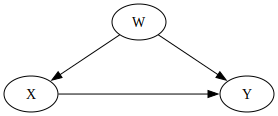

In [34]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'W', 'Y']
positions = ['1,0!', '2.5,1!', '4,0!']

edges = ['XY', 'WY', 'WX']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(r'C:\Users\aleks\OneDrive\Pulpit\BCKDR.png')

graph

## Chapter 07 - The Four-Step Process of Causal Inference

In [35]:
import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Causal models with DoWhy & EconML

### Generate the data

In [37]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [38]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])
df

,X,Z,Y
0,3.845289,-1.875620,-0.930684
1,6.523203,-3.510182,-0.600855
2,1.782945,0.080058,0.604987
3,15.930953,-11.173829,-6.140774
4,6.731703,-4.810170,-2.131114
...,...,...,...
995,1.036405,0.160953,0.299677
996,1.658672,-0.662584,-0.359655
997,4.515851,-2.767242,-0.905786
998,4.257525,-2.411134,-1.251950


### Step 1: Modeling the problem
#### Step 1: Modeling the problem

In [39]:
# Create the graph describing the causal structure
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

#### Step 1.2 - define the DoWhy model

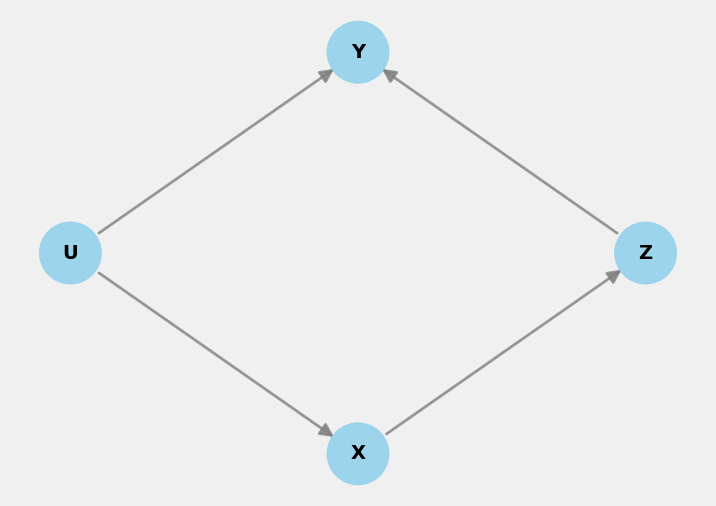

In [40]:
# With graph
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)

model.view_model()

### Step 2: Identify the estimand

In [41]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



### Step 3: Estimate the causal effect
#### Example 1 - Linear Regression

In [42]:
estimate = model.estimate_effect(
    identified_estimand=estimand,                 # Identified estimand
    method_name='frontdoor.two_stage_regression') # The name of the method

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): -0.42611633316838804


### Step 4: Run refutation tests

In [43]:
refute_subset = model.refute_estimate(  # Apply a refutation test to check robustness of the estimate
    estimand=estimand,                  # Use the identified causal estimand
    estimate=estimate,                  # Use the previously computed causal estimate
    method_name="data_subset_refuter",  # Use the subset refuter method: re-estimates using a data subset
    subset_fraction=0.4)                # Use only 40% of the data to test if the effect estimate holds

In [44]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.42611633316838804
New effect:-0.4264861500935327
p value:0.88



Refute: Use a subset of data

    We are testing the robustness of your causal effect estimate by re-estimating it on only 40% of the data.

Estimated effect: -0.4058

    This is our original causal estimate from the full dataset.

New effect: -0.4089

    This is the new causal estimate computed using the subset (40%) of the data (the two values are very close — this suggests your result is robust to subsetting the data).

p value: 0.78

    This p-value measures the statistical difference between the two estimates. A high p-value (like 0.78) means there is no significant difference between the original and subset-based estimates. This supports the robustness of your causal inference.

*Our causal estimate appears to be stable: even when using only 40% of the data, the effect estimate changes very little. This increases our confidence in the validity of the estimated causal effect.*

## Full example
### Data

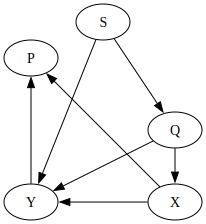

In [45]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']

edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_07_full_example')

graph

In [46]:
np.random.seed(45)
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])
df

,S,Q,X,Y,P
0,0.989012,0.496047,0.155169,0.668973,0.409711
1,0.549545,0.481445,0.255213,0.577403,0.306254
2,0.281447,0.241162,0.254216,0.337073,0.245756
3,0.077290,0.400174,0.353223,0.328995,0.406201
4,0.444469,0.232031,0.264994,0.548773,0.266438
...,...,...,...,...,...
995,0.549897,0.566631,0.309752,0.599328,0.270846
996,0.319892,0.481054,0.198266,0.419009,0.354445
997,0.281740,0.135864,0.087821,0.239395,0.247034
998,0.444334,0.737701,0.466480,0.574695,0.469751


In [47]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'


print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


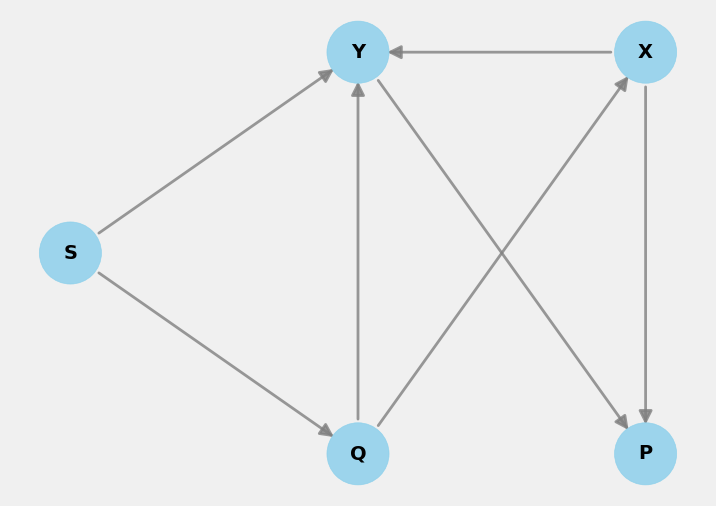

In [48]:
# Instantiate the CausalModel 
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)


model.view_model()

In [49]:
# Get the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



    Although our graph looks a bit complex, it contains only one back-door path. Controlling for Q deconfounds the relationship between X and Y.

In [50]:
estimate = model.estimate_effect(                           # Estimate the causal effect using the specified method
    identified_estimand=estimand,                           # Use the previously identified estimand (causal query)
    method_name='backdoor.econml.dml.DML',                  # Use the Double Machine Learning (DML) method via EconML
    method_params={                                         # Provide parameters for the DML model
        'init_params': {                                    # Parameters to initialize the DML estimator
            'model_y': GradientBoostingRegressor(),         # Model to predict the outcome (Y) from covariates
            'model_t': GradientBoostingRegressor(),         # Model to predict the treatment (T) from covariates
            'model_final': LassoCV(fit_intercept=False),    # Final stage model to estimate treatment effect
        },
        'fit_params': {}}                                   # Optional fitting parameters (empty here)
)

print(f'Estimate of causal effect (DML): {estimate.value}') # Print the estimated causal effect from the DML model

Estimate of causal effect (DML): 0.6809619014126588


For the sake of comparison, let’s see the results of linear regression:

In [51]:
estimate_lr = model.estimate_effect(                        # Estimate the causal effect using a simple method
    identified_estimand=estimand,                           # Use the previously defined causal estimand
    method_name='backdoor.linear_regression')               # Choose linear regression for effect estimation (back-door adjustment)

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')  # Display the estimated causal effect using linear regression

Estimate of causal effect (linear regression): 0.6817026695754441


In [52]:
random_cause = model.refute_estimate(                       # Apply a robustness check to test for hidden confounding
    estimand=estimand,                                      # Use the identified causal estimand
    estimate=estimate,                                      # Use the previously computed causal effect estimate
    method_name='random_common_cause'                       # Add a random variable as a fake confounder to see if it changes the estimate
)

print(random_cause)

Refute: Add a random common cause
Estimated effect:0.6809619014126588
New effect:0.6584961890991101
p value:0.24



We see that there is a difference between the estimated effect (0.69814…) and the new effect (0.66915…),
yet according to the provided p-value, this difference is not significant at the customary 0.05 level. If
we accept this rule, we need to agree that the model has passed the test.

Let’s try one more refutation test. This time, we’ll replace our treatment variable with a random
placebo variable:

In [53]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.6809619014126588
New effect:0.0
p value:1.0



This result is a clear indication that the placebo treatment had zero effect, which is the expected result
for a healthy model.

It seems that our model passed both tests! Note that the first test (random common cause) belonged
to the category of *invariant transformations*, while the second (placebo treatment) belonged to the
category of *nullifying transformations*.

## GCM API

In [54]:
import networkx as nx
from dowhy import gcm

In [55]:
np.random.seed(45)
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])
df

,S,Q,X,Y,P
0,0.989012,0.496047,0.155169,0.668973,0.409711
1,0.549545,0.481445,0.255213,0.577403,0.306254
2,0.281447,0.241162,0.254216,0.337073,0.245756
3,0.077290,0.400174,0.353223,0.328995,0.406201
4,0.444469,0.232031,0.264994,0.548773,0.266438
...,...,...,...,...,...
995,0.549897,0.566631,0.309752,0.599328,0.270846
996,0.319892,0.481054,0.198266,0.419009,0.354445
997,0.281740,0.135864,0.087821,0.239395,0.247034
998,0.444334,0.737701,0.466480,0.574695,0.469751


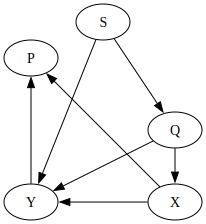

In [56]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']

edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

#graph.render(f'images/ch_07_full_example')

graph

In [57]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

nx.draw(
    graph_nx, 
    with_labels=True, 
    node_size=900,
    font_color='white', 
    node_color=COLORS[0]
)

In [58]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)    # Invertible SCM

causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node P: 100%|███████████████████████████████████████████████| 5/5 [00:00<00:00, 539.29it/s]


In [59]:
gcm.arrow_strength(causal_model, 'Y')

{('Q', 'Y'): 0.00047998273360639276,
 ('S', 'Y'): 0.008866375554715077,
 ('X', 'Y'): 0.006778137499361718}

In [60]:
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5], Y=[.75], S=[.5], Q=[.4], P=[.34])))

,S,Q,X,Y,P
0,0.5,0.4,0.21,0.548398,0.178888


    Counterfactuals from our GCM when X is set to 0.21.